# HW2- Machine Learning in Healthcare 336546

In this assignment we will be exploring T1D data, creating linear and non-linear ML classifiers and going through the process of
validating and evaluating the models.
Let's prepare the needed python libraries:

In [1]:
import numpy as np
from numpy import save, load
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, make_scorer , roc_curve
from sklearn.ensemble import RandomForestClassifier as RF
import pandas as pd
import xgboost as xgbst
from prettytable import PrettyTable
import seaborn as sns
from print_figures_and_tabels import print_roc_curve, print_violinplot, print_hyperparameters_heatmap ,print_result_tables
import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')


# Part 1: data exploration
First we want to load the data.
Our database inclused information about 565 patients, with data in 18 different featuers:

In [2]:
output ="Notebook"
csv_path = "HW2_data.csv"
df = pd.read_csv(csv_path, low_memory=False)
df.head()

,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Diagnosis,Family History
0,45,Male,No,No,No,Yes,No,No,No,Yes,No,No,Yes,No,Yes,No,Negative,0
1,42,Male,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Negative,0
2,45,Male,Yes,Yes,No,Yes,No,Yes,No,No,No,Yes,No,No,Yes,No,Positive,0
3,59,Female,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Positive,1
4,40,Female,Yes,Yes,Yes,Yes,No,No,Yes,Yes,No,No,Yes,Yes,No,No,Positive,0


## pre-processing

The first problem we'll have to face when dealing with the data is changing categorical values (Yes/No) into binary or numeric values that are easier to work with programing wise:

In [3]:
df_dum = pd.get_dummies(data =df,drop_first =True)
df_dum.head()

,Age,Family History,Gender_Male,Increased Urination_Yes,Increased Thirst_Yes,Sudden Weight Loss_Yes,Weakness_Yes,Increased Hunger_Yes,Genital Thrush_Yes,Visual Blurring_Yes,Itching_Yes,Irritability_Yes,Delayed Healing_Yes,Partial Paresis_Yes,Muscle Stiffness_Yes,Hair Loss_Yes,Obesity_Yes,Diagnosis_Positive
0,45,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0
1,42,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,45,0,1,1,1,0,1,0,1,0,0,0,1,0,0,1,0,1
3,59,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,40,0,0,1,1,1,1,0,0,1,1,0,0,1,1,0,0,1


Now that our data is numeric, we can go on and describe it, to get an idea of each feature's distribution in the data:

In [4]:
df_dum.describe()


,Age,Family History,Gender_Male,Increased Urination_Yes,Increased Thirst_Yes,Sudden Weight Loss_Yes,Weakness_Yes,Increased Hunger_Yes,Genital Thrush_Yes,Visual Blurring_Yes,Itching_Yes,Irritability_Yes,Delayed Healing_Yes,Partial Paresis_Yes,Muscle Stiffness_Yes,Hair Loss_Yes,Obesity_Yes,Diagnosis_Positive
count,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000
mean,48.169912,0.506195,0.637168,0.483186,0.428319,0.403540,0.571681,0.435398,0.215929,0.449558,0.474336,0.235398,0.461947,0.426549,0.357522,0.357522,0.168142,0.607080
std,12.295828,0.500405,0.481243,0.500160,0.495274,0.491042,0.495274,0.496248,0.411830,0.497890,0.499783,0.424623,0.498992,0.495014,0.479695,0.479695,0.374323,0.488832
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,57.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The second problem we want to deal with is that some values in our data might be missing. To solve this problem we will be finding NaN- missing values, and randomly replacing them with values from other subject, acccording to the data ratio for each feature- so we can still use those samples but not change the feature distribution unjustly.

In [5]:
for i in range(len(df_dum.iloc[1,:])):
    data_dum = np.array(df_dum.iloc[:,i],dtype= np.float64)
    data = df.iloc[:,i]
    clean = data_dum[np.invert(data.isna())]
    unique, counts = np.unique(clean, return_counts=True)
    p = counts/len(clean)
    a = data_dum[data.isna()]
    value =np.random.choice(unique, size=a.shape, replace=True, p=p)
    data_dum[data.isna()] = value
    df_dum.iloc[:,i]=data_dum

Before we manipulate the data any further, we want to take a look at the correlation matrix:

<AxesSubplot:>

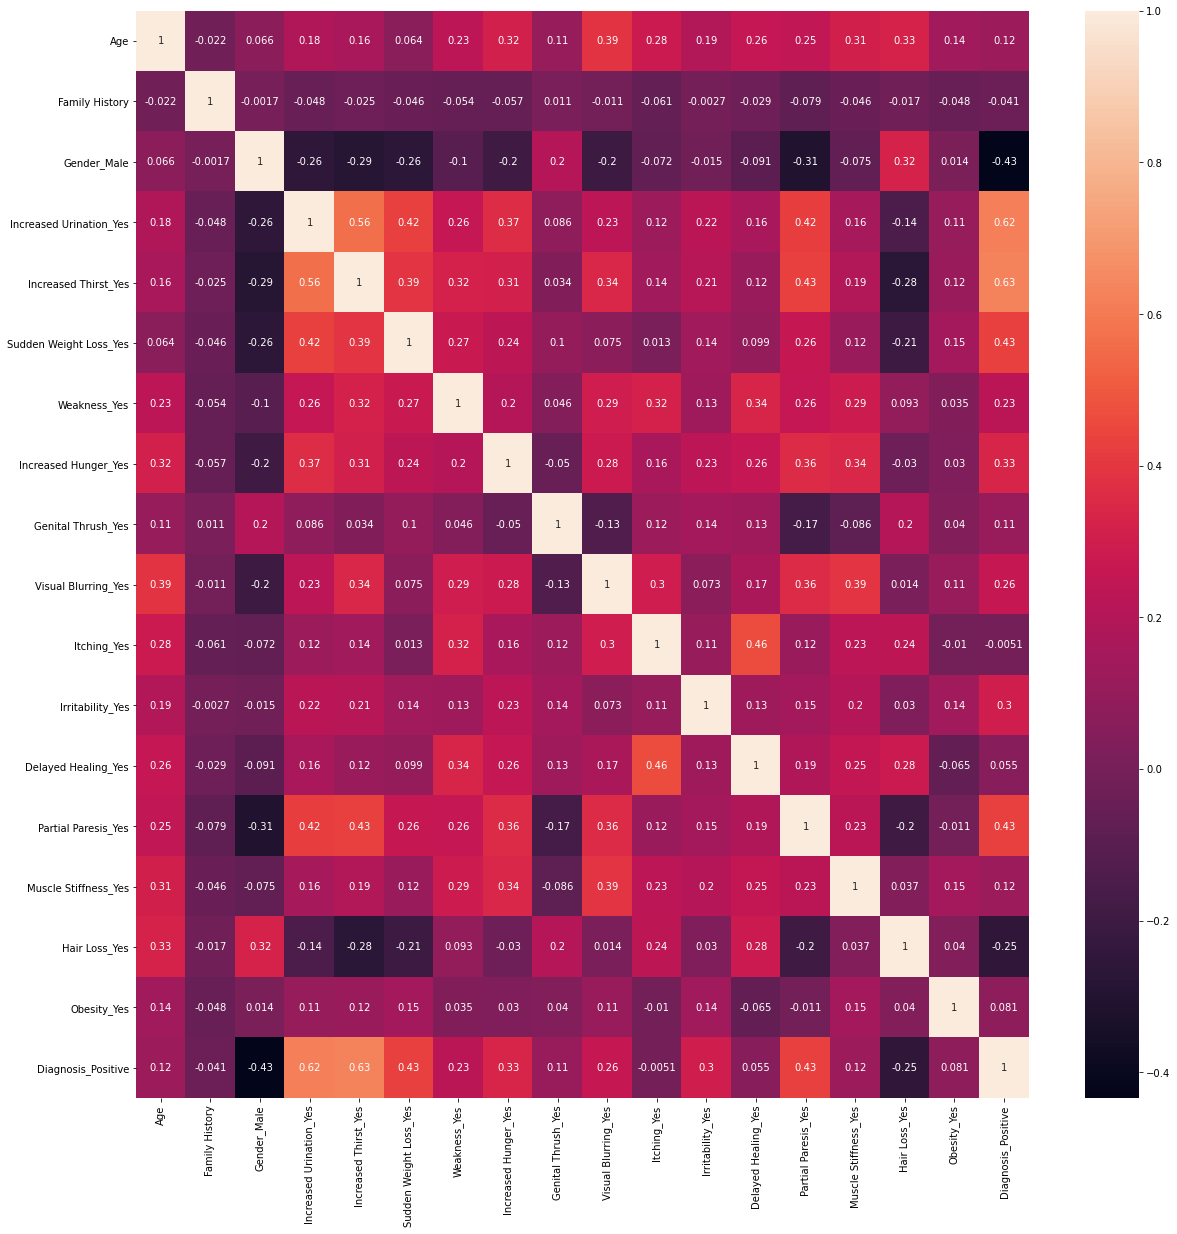

In [6]:
#correlation matrix plot
plt.figure(figsize = (20,20))
sns.heatmap(df_dum.corr(), annot = True)

We can see that the features that show the highest correlations with positive diagnosis are increased urination and increased thirst, and the highest negative correlation is with male gender. We should expect those to be the most significat features later in the classification process.

Now we want to separate the target y from the rest of the data base, and split the dat into train and test sets for our learning:

In [7]:
#Q2- train test split:
y = np.array(df_dum.Diagnosis_Positive)
df_dum =df_dum.drop('Diagnosis_Positive', axis= 1)
stat_all =df_dum.describe()

X_train, X_test, y_train, y_test =train_test_split(df_dum,y, test_size=0.2)

A problem that could arise at this step is imbalnce of features between the train and test sets. This could lead to training a model that's biased because of unrepresentative data, or getting low scores for an acceptable model due to bias in the test set. If we know that a certain model was trained on an imbalanced sata set, we can take different measures to correct for that, but this will usually be hardet. Another option is using a k-fold meths, where the model is trained on some of the data and checked on the rest repetedly.
Ideally, we would like both of our sets to include the same proportions for each feature as the original data, to minimize any complications.

To ensure that our train and test sets are "similar" enough in distribution and therefor using them won't create any of the problem mentioned, let's check the descriptive statistics of both sets and compare them: 

In [8]:
dist_table = PrettyTable()
dist_table.field_names =['feature', 'Train%','Test%', 'delta']
for i in range(2,len(df_dum.iloc[1,:])):
    train_counts =X_train.iloc[:,i].value_counts(normalize=True)
    test_counts = X_test.iloc[:, i].value_counts(normalize=True)
    dist_table.add_row([train_counts.name ,format(train_counts[1],'.2f'),format(test_counts[1],'.2f'),
    format(train_counts[1]-test_counts[1],'.2f')])

print(dist_table)

+-------------------------+--------+-------+-------+
|         feature         | Train% | Test% | delta |
+-------------------------+--------+-------+-------+
|       Gender_Male       |  0.63  |  0.66 | -0.03 |
| Increased Urination_Yes |  0.49  |  0.51 | -0.03 |
|   Increased Thirst_Yes  |  0.43  |  0.45 | -0.02 |
|  Sudden Weight Loss_Yes |  0.41  |  0.38 |  0.03 |
|       Weakness_Yes      |  0.58  |  0.56 |  0.02 |
|   Increased Hunger_Yes  |  0.44  |  0.46 | -0.02 |
|    Genital Thrush_Yes   |  0.20  |  0.27 | -0.06 |
|   Visual Blurring_Yes   |  0.45  |  0.44 |  0.00 |
|       Itching_Yes       |  0.46  |  0.51 | -0.05 |
|     Irritability_Yes    |  0.23  |  0.26 | -0.03 |
|   Delayed Healing_Yes   |  0.46  |  0.45 |  0.01 |
|   Partial Paresis_Yes   |  0.44  |  0.42 |  0.01 |
|   Muscle Stiffness_Yes  |  0.37  |  0.32 |  0.05 |
|      Hair Loss_Yes      |  0.35  |  0.38 | -0.03 |
|       Obesity_Yes       |  0.18  |  0.12 |  0.06 |
+-------------------------+--------+-------+--

As shown in the table above, the features appear in similar distributions in both sets. The biggest delta we get is of 0.08, which is a rather low value and overall acceptable for the sake of our model.

## Visualization:

To better understand our data, we want to continue and visualize it further, and plot the count for negative and positive results vs the values of each feature:

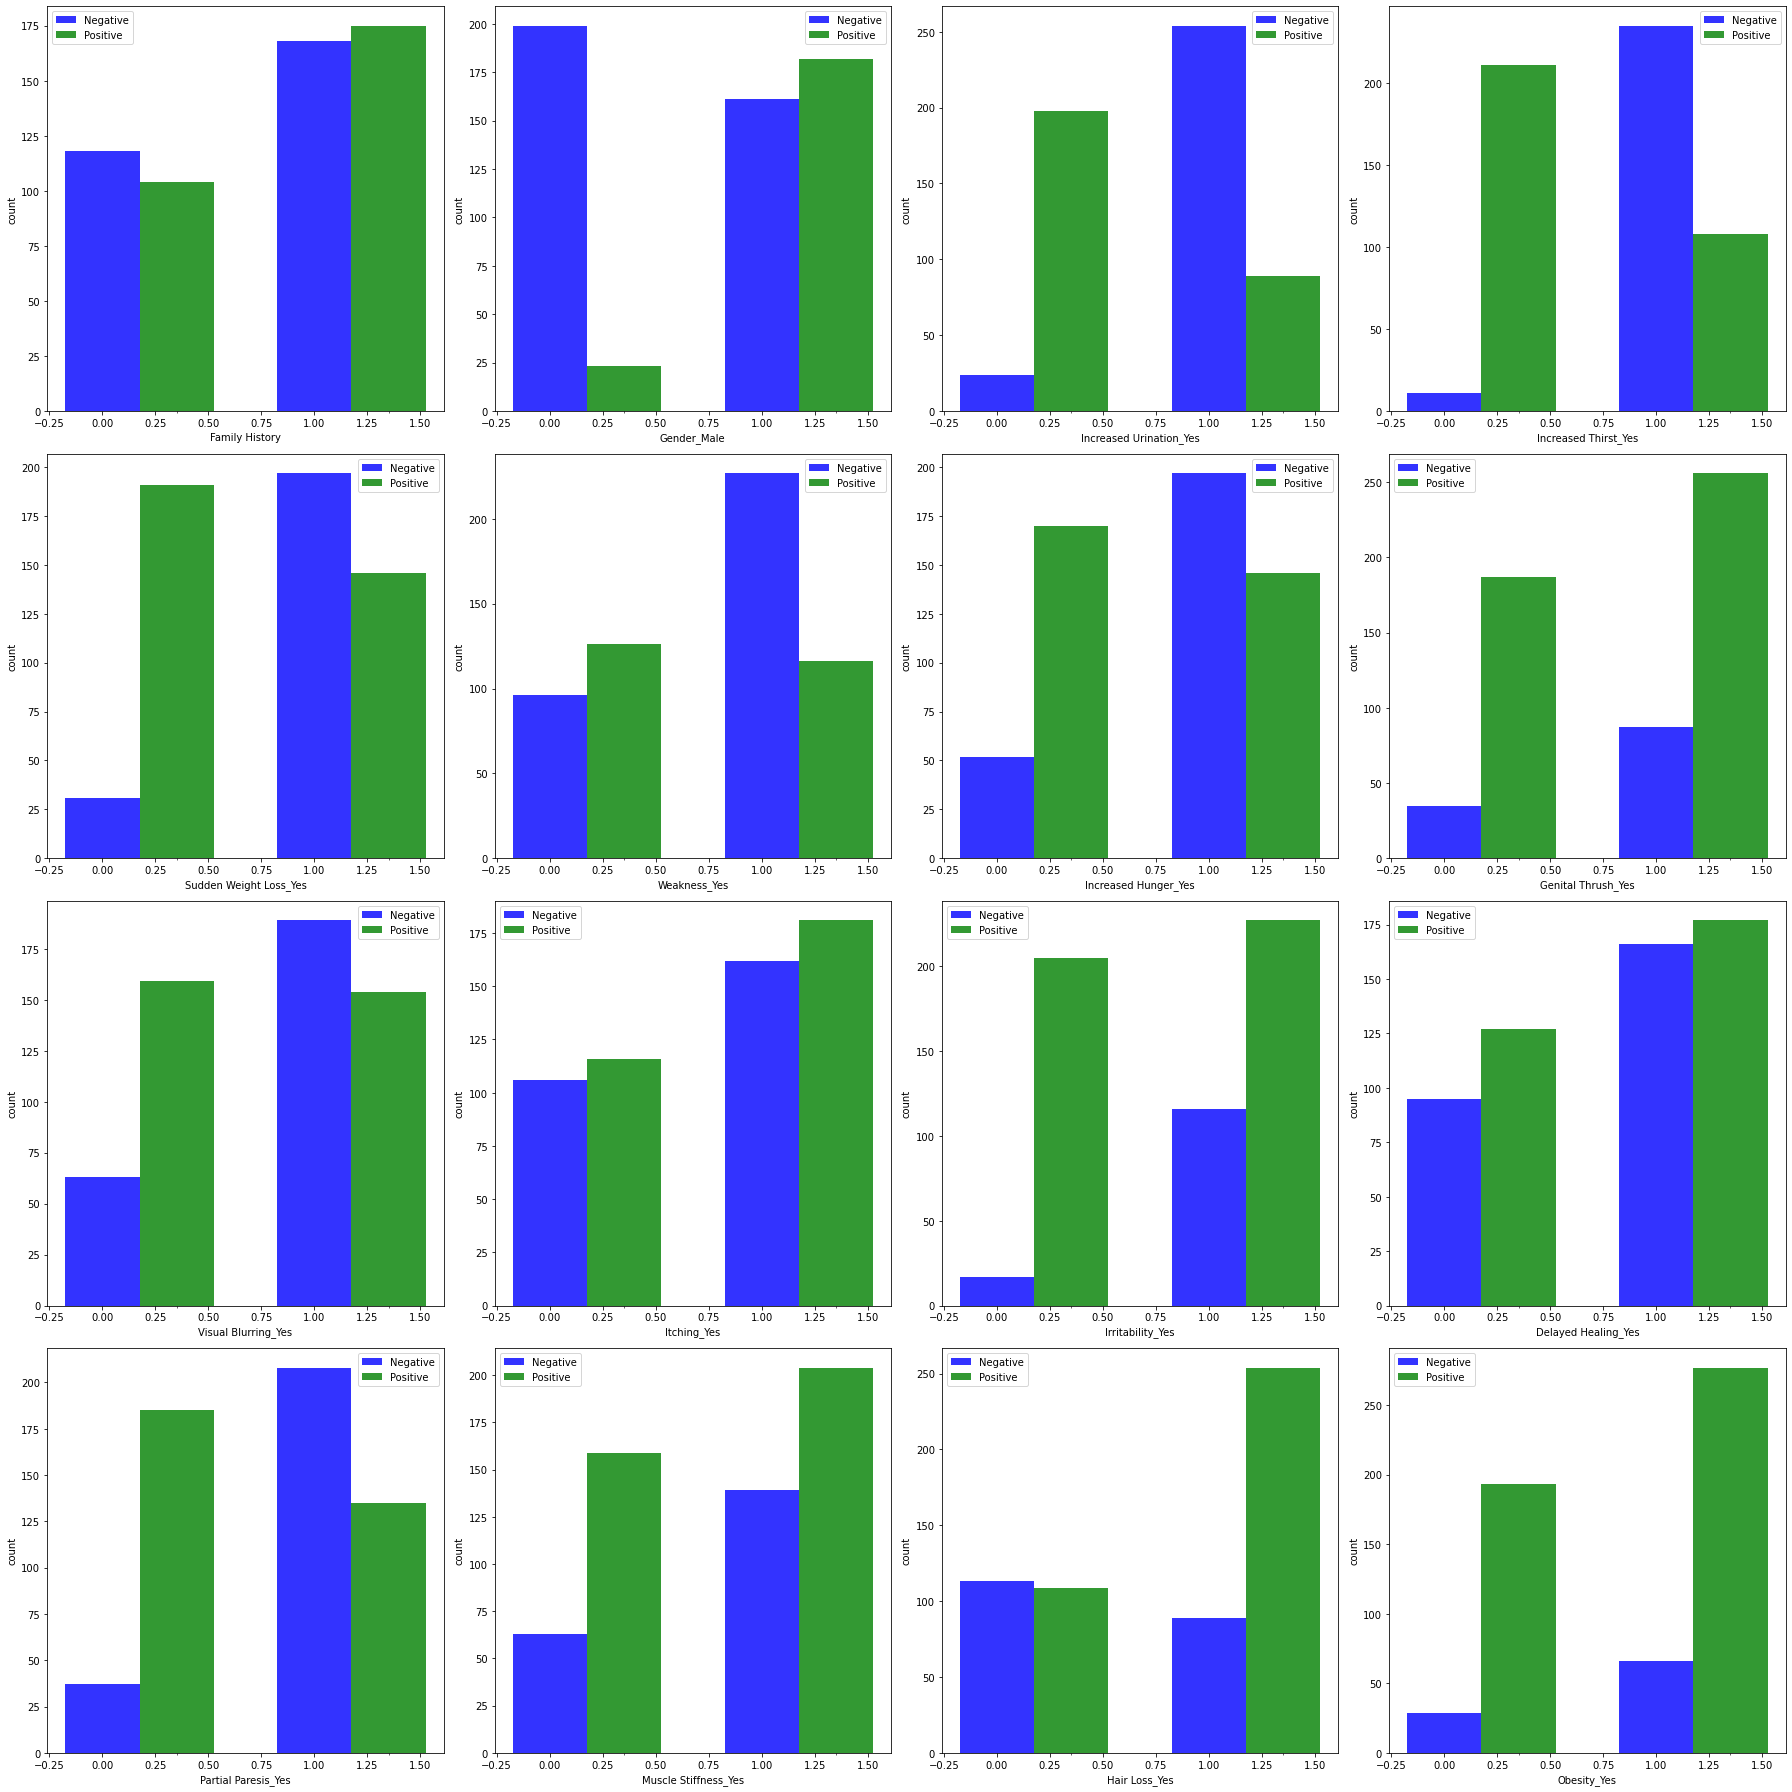

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize =(25,25))
for i in range(1,len(df_dum.iloc[1,:])):
    n_groups = 2
    dummy =np.array(df_dum.iloc[:,i])
    data1= (sum(dummy[y==0]),sum(dummy[y==1]))
    data2 =(len(dummy[y==0])-sum(dummy[y==0]),len(dummy[y==1])-sum(dummy[y==1]))

    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8
    ax_i = axes[int(((i-1) - ((i-1) % 4)) / 4), int((i-1) % 4)]
    rects1 = ax_i.bar(index, data1, bar_width,alpha=opacity,color='b',label='Negative')
    rects2 = ax_i.bar(index + bar_width, data2, bar_width,alpha=opacity,color='g',label='Positive')
    ax_i.set_xlabel(str(df_dum.iloc[:,i].name))
    ax_i.set_ylabel('count')
    ax_i.set_xticks(index + bar_width, ('feature positive', 'feature negative'))
    ax_i.legend()

plt.tight_layout()
plt.show()

From the graphs we can get a hint on the most influencing features- features that show a bigger difference between the probabilities of positive and negative are likely to be more informative for classification.
A quick look at the graphs tells us that increased urination and increased thirst are likely to be such features- similar to the conclusion from the feature correlation matrix.

# Part 2- training models

In this part we decided to train three different types of classifiers: 
* Logistic regression (a linear model)
* XGB (non-linear model)
* Random Forest model

we are using a cross-fold method with k=5, using 3 different hyperparameters.

In [10]:
#train three models by cross validation with hyperparameters, LR, RF, XGB

hyperparameters = {
                    'LR':
                        {
                            'C': np.array([0.1, 1, 10, 100, 1000]),
                        },
                    'RF':
                        {
                            'n_estimators': np.arange(20,90, 20, dtype=int),
                            'max_depth': np.arange(5, 15, 2)
                        },
                    'XGB':
                        {
                            'n_estimators': np.arange(110,201, 30, dtype=int),
                            'max_depth': np.arange(4,9, 2)
                        },
}
acc_scorer = make_scorer(accuracy_score)
lr = LR(random_state=0)
cf_lr = GridSearchCV(lr, param_grid =hyperparameters['LR'], scoring =acc_scorer, return_train_score= True)
cf_lr.fit(X_train, y_train)

xgb=xgbst.XGBClassifier(random_state=1,learning_rate=0.01,verbosity = 0 )
cf_xgb = GridSearchCV(xgb, param_grid =hyperparameters['XGB'], scoring =acc_scorer,return_train_score= True)
model_xgb =cf_xgb.fit(X_train, y_train)

rf = RF(random_state=0)
cf_rf = GridSearchCV(rf, param_grid =hyperparameters['RF'], scoring =acc_scorer,return_train_score= True)
cf_rf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': array([ 5,  7,  9, 11, 13]),
                         'n_estimators': array([20, 40, 60, 80])},
             return_train_score=True, scoring=make_scorer(accuracy_score))

To compare the different clssifiers, we'll now plot the ROC curve, violin plot and heat map for each of the classifiers.
To get some quantitive comparison we'll print decriptive statistics and evaluation of the classifiers by different metrics:

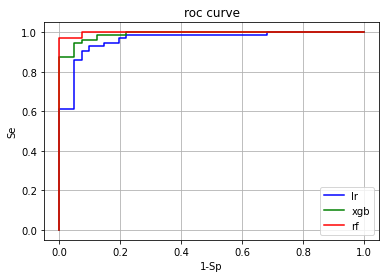

In [11]:
print_roc_curve(cf_lr, cf_xgb, cf_rf, X_test, y_test)

The ideal ROC curve has a square shape. Looking at our resutls, we can see that the RF model performed the best, and the linear model is the worse than the two non-linear models.

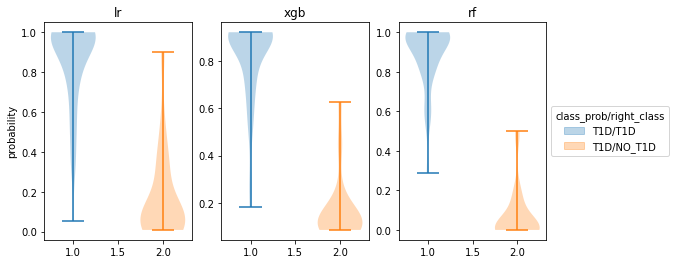

In [12]:
print_violinplot(cf_lr, cf_xgb, cf_rf, X_test, y_test)

The same is ilustrated by the above violin plots. We can see that the under the RF model the diagnosis is most sepretable, and that the linear regression model has the lowest seprability.

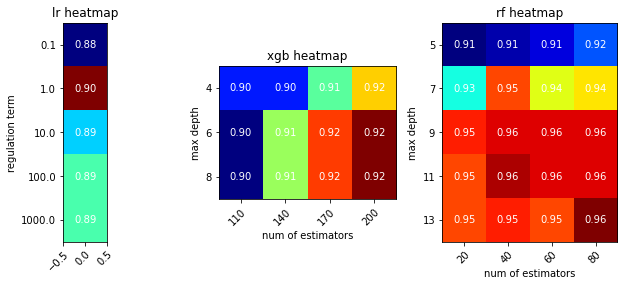

In [13]:
 print_hyperparameters_heatmap(cf_lr, cf_xgb, cf_rf, X_test, y_test, hyperparameters)

The heat maps show that we're heading in the right direction with the number of parameters used in the model.

In [14]:
print_result_tables(cf_lr, cf_xgb, cf_rf, X_test, y_test,1,1)

+-------------+------+------+------+
|    Metric   |  LR  | XGB  |  RF  |
+-------------+------+------+------+
|   Accuracy  | 0.91 | 0.95 | 0.98 |
|   F1-Score  | 0.93 | 0.96 | 0.99 |
| Sensitivity | 0.92 | 0.94 | 0.97 |
| Specificity | 0.90 | 0.95 | 1.00 |
|     PPV     | 0.94 | 0.97 | 1.00 |
|     NPV     | 0.86 | 0.91 | 0.95 |
|    AUROC    | 0.96 | 0.99 | 1.00 |
+-------------+------+------+------+
+------------+------------------+-----------------+-----------------------+----------------------+---------------+
| Classifier | Mean train score | Std train score | Mean validation score | Std validation score | test    score |
+------------+------------------+-----------------+-----------------------+----------------------+---------------+
|     LR     |      0.921       |      0.0131     |         0.903         |        0.0258        |      0.91     |
|    XGB     |      0.969       |      0.0044     |         0.925         |        0.0265        |      0.95     |
|     RF     |    

Scoring our models in different methods, we see once again that the both non-linear models out perform the linear one in all measures. we can also note that the RF model is doing slightly better than the XGB model by most evaluations.

The second table we printed includes the mean and standard deviation from the cross-validation we performed. It is important to check those, because they give us additional insights:
* If the mean between of the train set is larger than in the validation set, it indicates over-fitting of the model. 
* High STD values shows a success over a random fold that doesn't represent the full data

From our table we can see that our mean values are not very different and that all of our STDs are small, meaning that our models don't suffer from these problems.

## Feature selection:

To make better feature selection, we can derive feature importance from our random forest model:

Feature ranking:
1. feature 4 (0.213417)
2. feature 3 (0.147395)
3. feature 0 (0.101241)
4. feature 2 (0.082562)
5. feature 5 (0.076218)
6. feature 13 (0.067398)
7. feature 15 (0.043277)
8. feature 7 (0.037422)
9. feature 9 (0.036814)
10. feature 12 (0.034047)
11. feature 11 (0.031441)
12. feature 10 (0.026622)
13. feature 6 (0.025296)
14. feature 8 (0.023560)
15. feature 14 (0.022310)
16. feature 16 (0.019149)
17. feature 1 (0.011831)


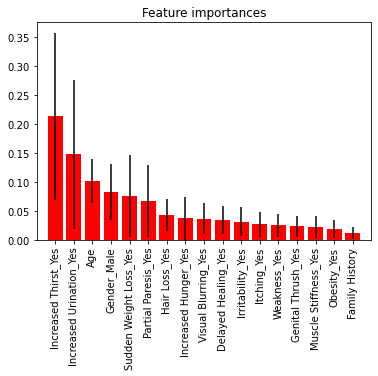

In [15]:
importances = cf_rf.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in cf_rf.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), df_dum.columns[indices],rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

As expected from the correlation matrix and data exploration done earlier in this assignment, we see that the most importat feature in determining whether a patient has TD1 are 
increased urination, increased thirst and gender.

# Part 3: Data separability analysis

In order to visualize data separability, we'll perform PCA anlysis:

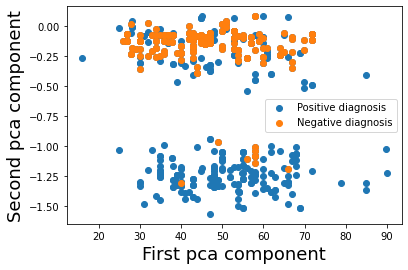

In [16]:
hyperparameters2 = {
                    'LR':
                        {
                            'C': np.array([0.1, 1, 10]),
                        },
                    'RF':
                        {
                            'n_estimators': np.arange(10,40, 5, dtype=int),
                            'max_depth': np.arange(5, 12, 2)
                        },
                    'XGB':
                        {
                            'n_estimators': np.arange(10,40, 5, dtype=int),
                            'max_depth': np.arange(2,7, 1)
                        },
}


pca = PCA()
X_pca_train =pca.fit(X_train)#!!!!
PC_features_train = np.matmul(X_train,X_pca_train.components_).iloc[:,0:2]
PC_features_test = np.matmul(X_test,X_pca_train.components_).iloc[:,0:2]

PC_features_train = PC_features_train.to_numpy()
PC_features_test = PC_features_test.to_numpy()


plt.scatter(PC_features_train[:,0],PC_features_train[:,1])
plt.scatter(PC_features_train[y_train==0,0], PC_features_train[y_train==0,1])
plt.xlabel("First pca component", fontsize=18)
plt.ylabel("Second pca component", fontsize=18)
plt.legend(('Positive diagnosis', 'Negative diagnosis'))
plt.show()

We can see that the negative diagnosis could be almost completly seperated by these two components alone, but making the classification based only on two parameters will give us a model with high rates of false negatives.

Repeating the process from earlier, we will now train three models with only the two most important features, and print the results:

In [17]:
lr = LR(random_state=0)
cf_lr_pc = GridSearchCV(lr, param_grid =hyperparameters2['LR'], scoring =acc_scorer, return_train_score= True)
cf_lr_pc.fit(PC_features_train, y_train)

xgb=xgbst.XGBClassifier(random_state=1,learning_rate=0.01 )
cf_xgb_pc = GridSearchCV(xgb, param_grid =hyperparameters2['XGB'], scoring =acc_scorer,return_train_score= True)
model_xgb =cf_xgb_pc.fit(PC_features_train, y_train)

rf = RF(random_state=0)
cf_rf_pc = GridSearchCV(rf, param_grid =hyperparameters2['RF'], scoring =acc_scorer,return_train_score= True)
cf_rf_pc.fit(PC_features_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': array([ 5,  7,  9, 11]),
                         'n_estimators': array([10, 15, 20, 25, 30, 35])},
             return_train_score=True, scoring=make_scorer(accuracy_score))

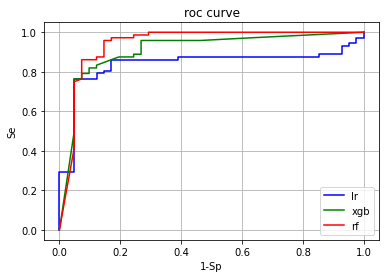

In [18]:
print_roc_curve(cf_lr_pc, cf_xgb_pc, cf_rf_pc , PC_features_test, y_test)

We can see that all models performed less when reducing to only two parameters, and that the "hirarchy" between them remaines: the RF model is still best at seperating the data, and the linear model is far behind the two non-linear models.

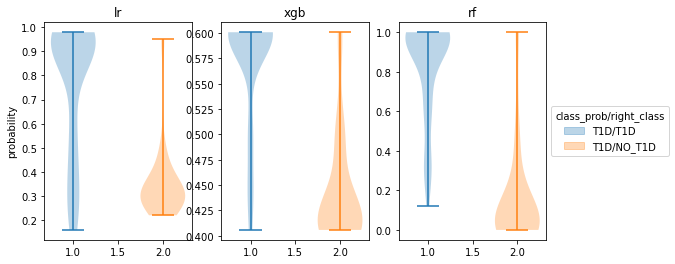

In [19]:
print_violinplot(cf_lr_pc, cf_xgb_pc, cf_rf_pc , PC_features_test, y_test)

Comparing the new violin plots to the first ones, we see that the seperation is worse in the two-feature models, but the most seperation is by the RF model as earlier.

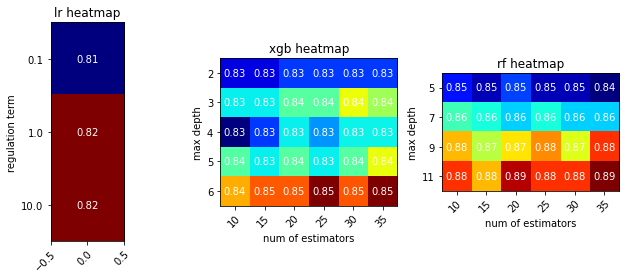

In [20]:
print_hyperparameters_heatmap(cf_lr_pc, cf_xgb_pc, cf_rf_pc, PC_features_test, y_test, hyperparameters2)

In [21]:
print_result_tables(cf_lr_pc, cf_xgb_pc, cf_rf_pc , PC_features_test, y_test,1,1)

+-------------+------+------+------+
|    Metric   |  LR  | XGB  |  RF  |
+-------------+------+------+------+
|   Accuracy  | 0.83 | 0.84 | 0.88 |
|   F1-Score  | 0.85 | 0.87 | 0.91 |
| Sensitivity | 0.76 | 0.82 | 0.86 |
| Specificity | 0.95 | 0.88 | 0.93 |
|     PPV     | 0.96 | 0.92 | 0.95 |
|     NPV     | 0.70 | 0.73 | 0.79 |
|    AUROC    | 0.84 | 0.91 | 0.94 |
+-------------+------+------+------+
+------------+------------------+-----------------+-----------------------+----------------------+---------------+
| Classifier | Mean train score | Std train score | Mean validation score | Std validation score | test    score |
+------------+------------------+-----------------+-----------------------+----------------------+---------------+
|     LR     |      0.817       |      0.0111     |         0.818         |        0.0505        |      0.83     |
|    XGB     |      0.904       |      0.0067     |         0.849         |        0.0210        |      0.84     |
|     RF     |    

From the evaluation metrics we can see that best preformance is still from the RF model, with significant difference from the other two models under most metrics.
In the second table, as earlier, we see similar mean values and low enough STD values, indicating that our classifiers are not biased.

Lastly, we will now train three classifiers based only on the best two features found in our feature selection analysis:

In [22]:

X_train =X_train.to_numpy()
X_test =X_test.to_numpy()
rf_train =X_train[:,[indices[0], indices[1]]]
rf_test =X_test[:,[indices[0], indices[1]]]

lr = LR(random_state=0, C =1)
lr.fit(rf_train, y_train)

xgb=xgbst.XGBClassifier(random_state=1,learning_rate=0.01,n_estimators=1, max_depth=3)
model_xgb =xgb.fit(rf_train, y_train)

rf = RF(random_state=0,n_estimators=1, max_depth=3)
rf.fit(rf_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=1, random_state=0)

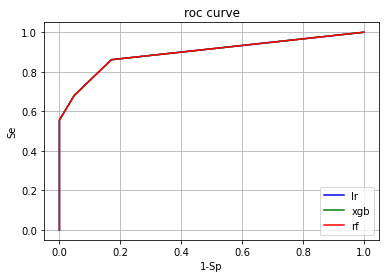

In [23]:
print_roc_curve(lr, xgb, rf, rf_test, y_test)

These ROC curves show that contrary to our earlier trainings, the non-linear models don't have an advantage over the linear one. This is reasonable, considering that having two features means that our data is seperated to four point: (0,0) (0,1) (1,0) (1,1).
Given that, the seperations possible are limited and could be covered by the linear model.

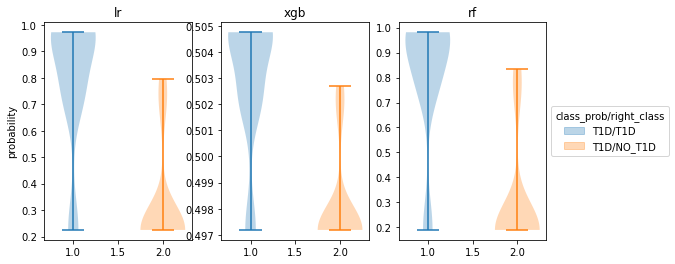

In [24]:
print_violinplot(lr, xgb, rf, rf_test, y_test)

Here we can see that all three models are able to seperate to the same extent, with no differenece between them

In [25]:
print_result_tables(lr, xgb, rf, rf_test, y_test,1,0)

+-------------+------+------+------+
|    Metric   |  LR  | XGB  |  RF  |
+-------------+------+------+------+
|   Accuracy  | 0.85 | 0.85 | 0.85 |
|   F1-Score  | 0.88 | 0.88 | 0.88 |
| Sensitivity | 0.86 | 0.86 | 0.86 |
| Specificity | 0.83 | 0.83 | 0.83 |
|     PPV     | 0.90 | 0.90 | 0.90 |
|     NPV     | 0.77 | 0.77 | 0.77 |
|    AUROC    | 0.90 | 0.90 | 0.90 |
+-------------+------+------+------+


The table shows us the exact same result- reducing the models to only two features makes their performance the same.

# The end